## Chladni (Tolkien) Figures

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
from tqdm import tqdm
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [4]:
class ImageProcessor:
    
    #Applies a filter toroidally
    def filterMatrixToroidally(self, matrix, filterMatrix):
        nFilter = np.size(filterMatrix,0)
        mFilter = np.size(filterMatrix,1)
        
        if(nFilter != mFilter):
            print("Filter needs to be a square matrix")
            return -1
        
        nMatrix = np.size(matrix,0)
        mMatrix = np.size(matrix,1)
        
        filteredMatrix = np.zeros((nMatrix, mMatrix))
        midSizeFilter = int(np.floor(nFilter/2))
        
        for i in range(0,nMatrix):
            for j in range(0,mMatrix):
                filteredValue = 0
                for s in range(-midSizeFilter,midSizeFilter+1):
                    for l in range(-midSizeFilter,midSizeFilter+1):
                        filteredValue = filteredValue + matrix[(i+s)%nMatrix, (j+l)%mMatrix]*filterMatrix[s + midSizeFilter, l + midSizeFilter]
                filteredMatrix[i,j] = filteredValue

        return filteredMatrix
    
    def filterMatrixWithZeros(self, matrix, filterMatrix):
        nFilter = np.size(filterMatrix,0)
        mFilter = np.size(filterMatrix,1)
        
        if(nFilter != mFilter):
            print("Filter needs to be a square matrix")
            return -1
        padSize = int(np.floor(nFilter/2))
        nMatrix = np.size(matrix,0)
        mMatrix = np.size(matrix,1)
        extendedMatrix = np.zeros((nMatrix+2*padSize, mMatrix+2*padSize))
        extendedMatrix[padSize:padSize + nMatrix, padSize:padSize + mMatrix] = matrix
        filteredMatrix = np.zeros((nMatrix,mMatrix))
        for i in range(0,nMatrix):
            for j in range(0,mMatrix):
                filteredValue = 0
                for s in range(-padSize,padSize+1):
                    for l in range(-padSize,padSize+1):
                        filteredValue = filteredValue + extendedMatrix[i+padSize+s, j+padSize+l]*filterMatrix[s + padSize, l + padSize]
                
                filteredMatrix[i, j] = filteredValue
        
        return filteredMatrix
        
    
    
    def getContour(self, matrix, value, epsilon = 0.01):
        nMatrix = np.size(matrix,0)
        mMatrix = np.size(matrix,1)
        contourMatrix = np.zeros((nMatrix, mMatrix))
        
        for i in range(0,nMatrix):
            for j in range(0,mMatrix):
                valMatrix = matrix[i,j]
                if(valMatrix >= value - epsilon and valMatrix <= value + epsilon):
                    contourMatrix[i,j] = 1
        
        return contourMatrix
    
    
                    
        
        
        

So strictly speaking Chladni requires many conditions but i don't have time or the ability right now to do that so let's try to break the thing into an approximate but simpler simulation.

I'll just start with the equation for a plate which goes something like this

\begin{equation}
\nabla^{4}u(x,y,t)  + \frac{\partial^{2}u(x,y,t)}{\partial t^{2}} = Q(x,y,t)
\end{equation}

Where Q is a forcing term. 

What i want to do is turn this into the rules of an automaton by discretization, and then $Q$ will be some sinusoidal applied in the middle of the plate, or in whichever position, we might even have many points where we apply it. This is similar to what people do in actual experiments with these plates, where they start making a periodic motion with the bow of a violin at the extreme of the plate. 

Well for $\nabla^{4}u(x,y,t)$ i figured that maybe just filtering with the stencil for the biharmonic operator might work (See <url>http://rodolphe-vaillant.fr/entry/57/2d-biharmonic-stencil-aka-bilaplacian-operator</url>).

Ant then well we know we can approximate the second partial with respect to time $\frac{\partial^{2}u}{\partial t^{2}}$ in the following way:

\begin{equation}
  \frac{\partial^{2}u}{\partial t^{2}} \approx\frac{u(x,y,t +h) -2u(x,y,t) + u(x,y,t-h)}{h^{2}} 
\end{equation}

We have 

\begin{equation}
u(x,y,t + h) = (Q(x,y,t) -\nabla^{4}u(x,y,t))h^{2} + 2u(x,y,t) - u(x,y,t-h)
\end{equation}

And that's it, this is our evolution rule for the automaton. Now let's implement it:

In [22]:

class InputSignalType(Enum):
    SINUSOIDAL = 0
    


class FakeChladni:
    
    def __init__(self, gridSize):
        self.biharmonicStencil = np.array([[0,0,1,0,0],[0,2,-8,2,0],[1,-8,20,-8,1],[0,2,-8,2,0],[0,0,1,0,0]])
        self.imageProcessor = ImageProcessor()
        self.gridSize = gridSize
    
    def setSources(self, sourcesX, sourcesY, frequencies,amplitudes, inputTypes):
        if(len(sourcesX) != len(sourcesY) or len(sourcesY) != len(frequencies) or len(inputTypes) != len(frequencies)):
            print("sourcesX, sourcesY, frequencies and inputTypes need to have the same length")
            return -1
        else:
            self.sourcesX = sourcesX
            self.sourcesY = sourcesY
            self.frequencies = frequencies
            self.inputTypes = inputTypes
            self.amplitudes = amplitudes
            
    
    #I've decided i will allow simulation of many sources, let's see how it goes. 
    def simulateAutomaton(self, nSteps, deltaT):
        nSources = len(self.sourcesX)
        sourcesSignals = np.zeros((nSteps, nSources))
        
        #Compute the input signals
        for i in range(0,nSources):
            inputType  = self.inputTypes[i]
            if(inputType == InputSignalType.SINUSOIDAL):
                tArray = np.linspace(0,nSteps*deltaT, nSteps)
                signal = self.amplitudes[i]*np.sin(2*np.pi*self.frequencies[i]*tArray)
                sourcesSignals[:,i] = signal
        
        self.automaton = np.zeros((self.gridSize, self.gridSize, nSteps + 1))
        for s in tqdm(range(1, nSteps + 1)):
            previousGrid = self.automaton[:,:,s - 1]
            newGridValues = np.zeros((self.gridSize, self.gridSize))
            #Forcing term
            for p in range(0,nSources):
                posX = self.sourcesX[p]
                posY = self.sourcesY[p]
                newGridValues[posY, posX] = newGridValues[posY, posX] + sourcesSignals[s - 1, p]*deltaT**2
                
            #Biharmonic operator
            newGridValues = newGridValues - self.imageProcessor.filterMatrixWithZeros(previousGrid, self.biharmonicStencil*deltaT**2)
            
            #Other 2 time terms
            for i in range(0,self.gridSize):
                for j in range(0,self.gridSize):
                    newGridValues[i,j] = newGridValues[i,j] + 2*previousGrid[i,j]
                    if(s - 2 >= 0):
                        newGridValues[i,j] = newGridValues[i,j] - self.automaton[i,j,s - 2]
            
            self.automaton[:,:,s] = newGridValues
        
    
    def getAutomatonFinalZeroContours(self):
        nSteps = np.size(self.automaton,2)
        return self.imageProcessor.getContour(self.automaton[:,:,nSteps -1], 0)
    
    
    def animateContourEvolution(self):
        self.fig, self.ax = plt.subplots()
        nSteps = np.size(self.automaton,2)
        duration = 20
        deltaT = (duration/nSteps)*10**3
        anim = FuncAnimation(self.fig, self.paintFrame, frames = nSteps, interval = deltaT, blit = False)
        return HTML(anim.to_html5_video())
        
    def paintFrame(self, i):
        if(i%10 == 0):
            print(i)
        imZeros = self.imageProcessor.getContour(self.automaton[:,:,i],0)
        self.ax.imshow(imZeros, cmap = "plasma")

#### Tests
Let's test it, this is the fun part

In [23]:
nPoints = 100
fakeChladni = FakeChladni(nPoints)

In [24]:

sourcesX = [int(nPoints/4), int(3*nPoints/4), int(nPoints/4), int(3*nPoints/4)]
sourcesY = [int(nPoints/4), int(nPoints/4), int(3*nPoints/4), int(3*nPoints/4)]
freq0 = 20
frequencies = [freq0,freq0,freq0, freq0]
A = 0.5
amplitudes = [A,A,A,A]
inputTypes = [InputSignalType.SINUSOIDAL,InputSignalType.SINUSOIDAL,InputSignalType.SINUSOIDAL,InputSignalType.SINUSOIDAL]
nSteps = 500
deltaT = 2/freq0

In [25]:
fakeChladni.setSources(sourcesX, sourcesY, frequencies, amplitudes,inputTypes)

In [26]:
fakeChladni.simulateAutomaton(nSteps, deltaT)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:45<00:00,  4.72it/s]


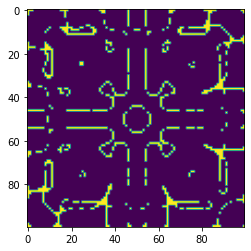

In [27]:
plt.figure()
plt.imshow(fakeChladni.getAutomatonFinalZeroContours())

0
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500


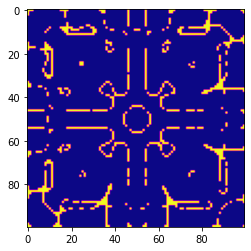

In [28]:
fakeChladni.animateContourEvolution()

array([[ 5.75720130e+25,  1.02571494e+26,  1.25029708e+26, ...,
        -2.71395052e+19, -1.40099944e+19, -4.73563165e+18],
       [ 1.02571494e+26,  1.82537188e+26,  2.22002223e+26, ...,
        -4.89161728e+19, -2.46361935e+19, -8.14125952e+18],
       [ 1.25029708e+26,  2.22002223e+26,  2.68692802e+26, ...,
        -6.05229994e+19, -2.90535798e+19, -9.13349908e+18],
       ...,
       [-2.71395052e+19, -4.89161728e+19, -6.05229994e+19, ...,
         4.94471518e+14,  1.11304806e+14, -1.51473454e+13],
       [-1.40099944e+19, -2.46361935e+19, -2.90535798e+19, ...,
         1.11304806e+14, -2.09156056e+13, -3.69699268e+13],
       [-4.73563165e+18, -8.14125952e+18, -9.13349908e+18, ...,
        -1.51473454e+13, -3.69699268e+13, -2.42502186e+13]])